In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, statistics, CoxPHFitter
from scipy.stats import norm, normaltest

In [2]:
conn = sqlite3.connect(r'C:\work\database\techTest_mod.db')

List all tables in the database

In [3]:
tables_df = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
tables = tables_df['name'].tolist()
print("Tables in the database are:", tables)

Tables in the database are: ['patient_mod', 'patient_diagnosis', 'patient_biomarker']


Schema for tables in the database

In [4]:
dfs = {}
for t in tables:
    df = pd.read_sql(f"SELECT * FROM {t}", conn)
    dfs[t] = df
    print(f"\nSchema for table '{t}' is :")
    print(df.dtypes)


Schema for table 'patient_mod' is :
patient_id      object
dob             object
dod             object
gender          object
current_age    float64
dtype: object

Schema for table 'patient_diagnosis' is :
patient_id             object
dob                    object
dod                    object
gender                 object
diagnosis_date         object
diagnosis_code         object
diagnosis_code_type    object
dtype: object

Schema for table 'patient_biomarker' is :
patient_id             object
dob                    object
dod                    object
gender                 object
test_date              object
biomarker_name         object
biomarker_test_type    object
test_result            object
dtype: object


Finding missing values

In [5]:
for t, df in dfs.items():
    print(f"\nFirst 5 rows of '{t}':")
    print(df.head())

    #Check for missing values
    missing_values = df.isnull().sum()
    print(f"\nMissing values in '{t}':")
    print(missing_values)


First 5 rows of 'patient_mod':
                             patient_id                  dob  \
0  019d3689-e49a-4f23-8ca1-65379907230b  1966-07-20 00:00:00   
1  dbed4b3e-33ba-4856-a78d-3db6d211def8  1963-04-30 00:00:00   
2  32808df0-103c-409e-ad6b-60ec55d60612  1944-03-20 00:00:00   
3  774e6b8d-245a-46cc-8e7d-56f30c5b3d3d  1932-06-24 00:00:00   
4  11c0cded-7982-4248-83bb-10a16870d76a  1951-05-24 00:00:00   

                   dod     gender  current_age  
0  2042-06-15 00:00:00     female    58.650240  
1  2036-01-19 00:00:00       NULL    61.872690  
2  1981-11-05 00:00:00  nonbinary    80.982888  
3  1977-04-11 00:00:00       male    92.720055  
4  1993-08-19 00:00:00     female    73.806982  

Missing values in 'patient_mod':
patient_id     0
dob            0
dod            0
gender         0
current_age    0
dtype: int64

First 5 rows of 'patient_diagnosis':
                             patient_id                  dob  \
0  019d3689-e49a-4f23-8ca1-65379907230b  1966-07-20 00:

Function for summary statistics

In [6]:
def sum_stat(data):
    print(data.describe(include='all'))

Function for histograms

In [7]:
def draw_hist_num(x, b, xl, yl, t):
    plt.figure(figsize=(8, 5))
    plt.hist(x, bins=b, color='black', edgecolor='beige')
    plt.xlabel(xl, fontsize=20, fontweight='bold')
    plt.ylabel(yl, fontsize=20, fontweight='bold')
    plt.xticks(ticks=tuple(b), fontsize=16, fontweight='bold')
    plt.yticks(fontsize=16, fontweight='bold')
    plt.title(t, fontsize=20, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
def normality(x):  
    #Check normality using D'Agostino's K-squared test
    k2, p_val = normaltest(x.dropna())
    print(f"Normaltest statistic: {k2:.3f}, p-value: {p_val:.3e}")
    
    if p_val < 0.05:
        print("Data is likely NOT normally distributed (reject H0).")
    else:
        print("Data is likely normally distributed (cannot reject H0).")

Question 1

Fetching initial diagnosis and last encounter for Breast Cancer patients

In [8]:
diagnosis_date = pd.read_sql("""
                        SELECT patient_id, MAX(diagnosis_date) AS last_encounter, MIN(diagnosis_date) AS initial_diagnosis 
                        FROM patient_diagnosis 
                        WHERE diagnosis_code LIKE 'C50%' 
                        GROUP BY patient_id
                        """, conn)

Fetching Patient data (Patient ID, dob, and dod)

In [9]:
patients_date = pd.read_sql("SELECT patient_id, dob, dod FROM patient_mod", conn)

Merging the 2 tables to get the columns 'patient_id', 'initial_diagnosis', 'last_encounter', 'dob', 'dod'

In [10]:
bc_data = pd.merge(patients_date, diagnosis_date, on='patient_id')

Calculating age at initial diagnosis and follow up time

In [11]:
bc_data['initial_diagnosis'] = pd.to_datetime(bc_data['initial_diagnosis'])
bc_data['last_encounter'] = pd.to_datetime(bc_data['last_encounter'])
bc_data['dob'] = pd.to_datetime(bc_data['dob'])

bc_data['age_at_initial_diagnosis'] = (bc_data['initial_diagnosis'] - bc_data['dob']).dt.days / 365.25
bc_data['follow_up_time'] = (bc_data['last_encounter'] - bc_data['initial_diagnosis']).dt.days / 365.25

Summary statistics for age at initial diagnosis and follow up time

In [12]:
print('Summary Statistics of Age at Initial Diagnosis: ')
sum_stat(bc_data['age_at_initial_diagnosis'])

print('\nSummary Statistics of Follow-up Time: ')
sum_stat(bc_data['follow_up_time'])

Summary Statistics of Age at Initial Diagnosis: 
count    646.000000
mean      32.641500
std       11.319376
min       19.195072
25%       23.963039
50%       29.783710
75%       38.358658
max       78.937714
Name: age_at_initial_diagnosis, dtype: float64

Summary Statistics of Follow-up Time: 
count    646.000000
mean      11.429548
std       12.793407
min        0.000000
25%        0.000000
50%        7.026694
75%       20.023272
max       52.580424
Name: follow_up_time, dtype: float64


Histograms

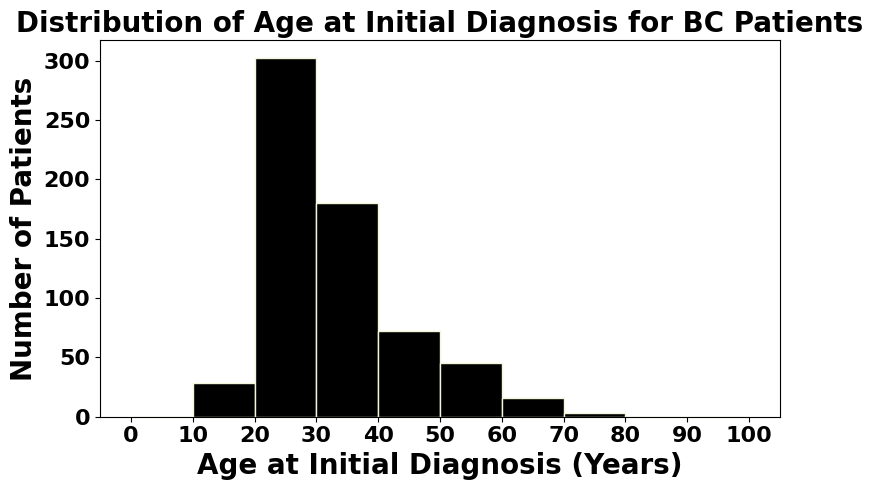

Normaltest statistic: 123.223, p-value: 1.748e-27
Data is likely NOT normally distributed (reject H0).


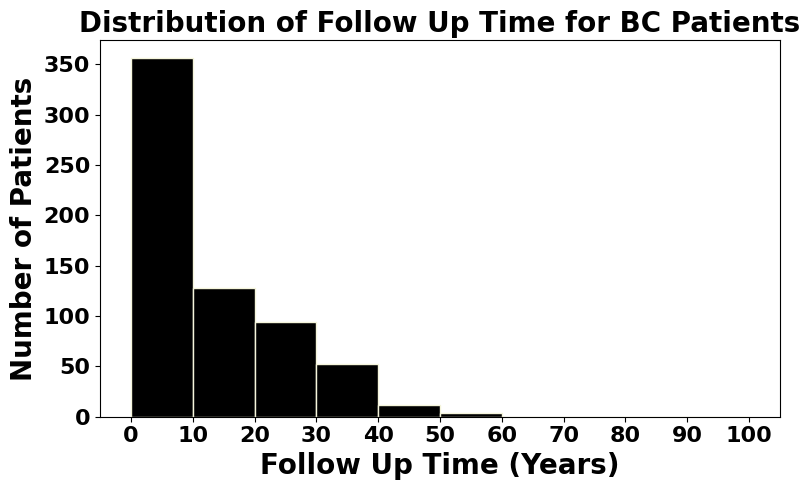

Normaltest statistic: 72.142, p-value: 2.161e-16
Data is likely NOT normally distributed (reject H0).


In [13]:
draw_hist_num(bc_data['age_at_initial_diagnosis'], range(0,110,10), 'Age at Initial Diagnosis (Years)', 'Number of Patients', 'Distribution of Age at Initial Diagnosis for BC Patients')
normality(bc_data['age_at_initial_diagnosis'])

draw_hist_num(bc_data['follow_up_time'], range(0,110,10), 'Follow Up Time (Years)', 'Number of Patients', 'Distribution of Follow Up Time for BC Patients')
normality(bc_data['follow_up_time'])

Question 2

Breast cancer patient IDs

In [14]:
bc_patients = bc_data['patient_id']

HER2 records for Breast cancer patients

In [15]:
her2 = pd.read_sql("""
                    SELECT * FROM patient_biomarker
                    WHERE biomarker_name = 'HER2'
                    AND patient_id IN ({})
                    """.format(','.join(["'{}'".format(pid) for pid in bc_patients])), conn)

Intent to test rate

In [16]:
intent_to_test_rate = her2['patient_id'].nunique() / len(bc_patients)
print("Intent to Test Rate for HER2 is {:.2%}".format(intent_to_test_rate))

Intent to Test Rate for HER2 is 74.15%


Tested rate

In [17]:
valid = ['Negative', 'Positive', 'Equivocal', 'Inconclusive']
tested_rate = her2[her2['test_result'].isin(valid)]['patient_id'].nunique() / len(bc_patients)
print("Tested Rate for HER2 is {:.2%}".format(tested_rate))

Tested Rate for HER2 is 65.48%


Negativity rate

In [18]:
negativity_rate = her2[her2['test_result'] == 'Negative']['patient_id'].nunique() / len(bc_patients)
print("Negativity Rate for HER2 is {:.2%}".format(negativity_rate))

Negativity Rate for HER2 is 29.72%


Question 3

Getting survival data 
(Assumption: Patient's dod is the event if it occurred before a censoring date)

In [19]:
patients_date['dod'] = pd.to_datetime(patients_date['dod'])
patients_date['dob'] = pd.to_datetime(patients_date['dob'])
survival_data = pd.merge(patients_date, bc_data[['patient_id', 'initial_diagnosis', 'age_at_initial_diagnosis']], on='patient_id')
survival_data['initial_diagnosis'] = pd.to_datetime(survival_data['initial_diagnosis'])

Defining a censoring date

In [20]:
censor = pd.to_datetime('2024-01-01')  #arbitrary

Calculating survival time

In [21]:
survival_data['event'] = survival_data['dod'].apply(lambda x: 1 if pd.notnull(x) and x <= censor else 0)
survival_data['end_date'] = survival_data.apply(lambda row: row['dod'] if row['event'] == 1 else censor, axis=1)
survival_data['survival_time'] = (survival_data['end_date'] - survival_data['initial_diagnosis']).dt.days/365.25

Stratifying patients by age at diagnosis (< 60 vs. >= 60)

In [22]:
group1 = survival_data[survival_data['age_at_initial_diagnosis'] < 60]
group2 = survival_data[survival_data['age_at_initial_diagnosis'] >= 60]

print("Summary Statistics for Group 1 (< 60 years):")
sum_stat(group1['survival_time'])

print("\nSummary Statistics for Group 2 (>= 60 years):")
sum_stat(group2['survival_time'])

Summary Statistics for Group 1 (< 60 years):
count    627.000000
mean      25.295750
std       13.108986
min        0.451745
25%       15.114305
50%       25.867214
75%       34.009582
max       60.695414
Name: survival_time, dtype: float64

Summary Statistics for Group 2 (>= 60 years):
count    19.000000
mean      6.879210
std       5.292065
min       0.010951
25%       2.544832
50%       6.439425
75%      10.548939
max      16.563997
Name: survival_time, dtype: float64


KM survival curve

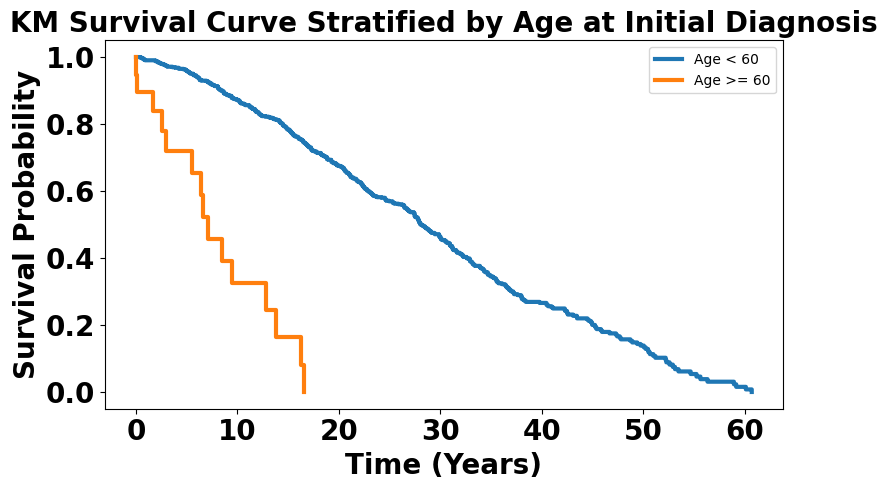

In [23]:
km = KaplanMeierFitter()
plt.figure(figsize=(8, 5))

km.fit(group1['survival_time'], event_observed=group1['event'], label='Age < 60')
ax = km.plot(ci_show=False, lw=3)

km.fit(group2['survival_time'], event_observed=group2['event'], label='Age >= 60')
km.plot(ax=ax, ci_show=False, lw=3)

plt.title('KM Survival Curve Stratified by Age at Initial Diagnosis', fontsize=20, fontweight='bold')
plt.xlabel('Time (Years)', fontsize=20, fontweight='bold')
plt.ylabel('Survival Probability', fontsize=20, fontweight='bold')
plt.xticks(fontsize=20, fontweight='bold')
plt.yticks(fontsize=20, fontweight='bold')

plt.tight_layout()
plt.show()

Log-rank test

In [24]:
results = statistics.logrank_test(group1['survival_time'], group2['survival_time'],
                                  event_observed_A=group1['event'], event_observed_B=group2['event'])
print("Log-Rank Test P-Value is", results.p_value)

Log-Rank Test P-Value is 1.2172155539394092e-20


In [25]:
conn.close()